In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

## Defining the Learning Parameters

In [3]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preparing the Dataset

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

#### download the dataset, change the second line, delete "..“

In [5]:
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data\MNIST\raw\train-images-idx3-ubyte.gz to input/data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data\MNIST\raw\train-labels-idx1-ubyte.gz to input/data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data\MNIST\raw\t10k-images-idx3-ubyte.gz to input/data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to input/data\MNIST\raw



## The Generator Neural Network

In [6]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

## The Discriminator Neural Network

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

## Initialize the Neural Networks and Define the Optimizers

In [8]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

In [9]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [10]:
# loss function
criterion = nn.BCELoss()

In [11]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

## Defining Some Utility Functions

In [12]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [13]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [14]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

## Function to Train the Discriminator

In [15]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

## Function to Train the Generator

In [16]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

## Training the GAN

In [17]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [18]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

## The Training Loop

#### Changed the file name

In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, "output/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:08, 13.48it/s]                                                                                               


Epoch 0 of 200
Generator loss: 3.59333730, Discriminator loss: 0.77117485


118it [00:08, 13.94it/s]                                                                                               


Epoch 1 of 200
Generator loss: 2.80410862, Discriminator loss: 1.42081690


118it [00:08, 13.48it/s]                                                                                               


Epoch 2 of 200
Generator loss: 2.91122818, Discriminator loss: 1.11393094


118it [00:08, 13.82it/s]                                                                                               


Epoch 3 of 200
Generator loss: 1.56586325, Discriminator loss: 1.07737577


118it [00:08, 13.79it/s]                                                                                               


Epoch 4 of 200
Generator loss: 2.03444695, Discriminator loss: 0.98646289


118it [00:08, 13.49it/s]                                                                                               


Epoch 5 of 200
Generator loss: 0.96826380, Discriminator loss: 1.38909543


118it [00:08, 13.64it/s]                                                                                               


Epoch 6 of 200
Generator loss: 0.84331584, Discriminator loss: 1.24702215


118it [00:09, 12.88it/s]                                                                                               


Epoch 7 of 200
Generator loss: 1.44261062, Discriminator loss: 0.88194329


118it [00:09, 13.00it/s]                                                                                               


Epoch 8 of 200
Generator loss: 1.44130313, Discriminator loss: 1.14262378


118it [00:08, 13.43it/s]                                                                                               


Epoch 9 of 200
Generator loss: 1.49162614, Discriminator loss: 0.88165045


118it [00:09, 13.00it/s]                                                                                               


Epoch 10 of 200
Generator loss: 1.63948107, Discriminator loss: 1.27163947


118it [00:08, 13.15it/s]                                                                                               


Epoch 11 of 200
Generator loss: 1.47688937, Discriminator loss: 0.84950328


118it [00:09, 12.74it/s]                                                                                               


Epoch 12 of 200
Generator loss: 1.80472994, Discriminator loss: 0.79034710


118it [00:09, 12.95it/s]                                                                                               


Epoch 13 of 200
Generator loss: 2.18552566, Discriminator loss: 0.64243400


118it [00:08, 13.22it/s]                                                                                               


Epoch 14 of 200
Generator loss: 2.52549982, Discriminator loss: 0.49303102


118it [00:08, 13.38it/s]                                                                                               


Epoch 15 of 200
Generator loss: 2.30588031, Discriminator loss: 0.59552294


118it [00:08, 13.52it/s]                                                                                               


Epoch 16 of 200
Generator loss: 2.88819551, Discriminator loss: 0.42273661


118it [00:08, 13.89it/s]                                                                                               


Epoch 17 of 200
Generator loss: 3.63536930, Discriminator loss: 0.37209061


118it [00:09, 12.85it/s]                                                                                               


Epoch 18 of 200
Generator loss: 3.44844174, Discriminator loss: 0.52761298


118it [00:09, 12.41it/s]                                                                                               


Epoch 19 of 200
Generator loss: 3.48784065, Discriminator loss: 0.47085580


118it [00:08, 13.69it/s]                                                                                               


Epoch 20 of 200
Generator loss: 3.04256964, Discriminator loss: 0.61012185


118it [00:08, 13.77it/s]                                                                                               


Epoch 21 of 200
Generator loss: 3.18405199, Discriminator loss: 0.39299241


118it [00:08, 13.69it/s]                                                                                               


Epoch 22 of 200
Generator loss: 2.89037561, Discriminator loss: 0.57191455


118it [00:08, 13.80it/s]                                                                                               


Epoch 23 of 200
Generator loss: 2.81264901, Discriminator loss: 0.48385000


118it [00:08, 13.77it/s]                                                                                               


Epoch 24 of 200
Generator loss: 3.09756303, Discriminator loss: 0.42814383


118it [00:08, 13.89it/s]                                                                                               


Epoch 25 of 200
Generator loss: 3.02443504, Discriminator loss: 0.58163005


118it [00:08, 13.88it/s]                                                                                               


Epoch 26 of 200
Generator loss: 2.93704081, Discriminator loss: 0.47818068


118it [00:08, 13.92it/s]                                                                                               


Epoch 27 of 200
Generator loss: 3.00826383, Discriminator loss: 0.49486986


118it [00:08, 13.76it/s]                                                                                               


Epoch 28 of 200
Generator loss: 2.78519750, Discriminator loss: 0.53925276


118it [00:08, 13.87it/s]                                                                                               


Epoch 29 of 200
Generator loss: 2.37561417, Discriminator loss: 0.69050908


118it [00:08, 13.94it/s]                                                                                               


Epoch 30 of 200
Generator loss: 2.65907288, Discriminator loss: 0.51180393


118it [00:08, 13.80it/s]                                                                                               


Epoch 31 of 200
Generator loss: 2.82580853, Discriminator loss: 0.62234759


118it [00:08, 13.85it/s]                                                                                               


Epoch 32 of 200
Generator loss: 2.71242380, Discriminator loss: 0.61203289


118it [00:08, 13.73it/s]                                                                                               


Epoch 33 of 200
Generator loss: 2.52582502, Discriminator loss: 0.58143657


118it [00:08, 13.59it/s]                                                                                               


Epoch 34 of 200
Generator loss: 2.83258438, Discriminator loss: 0.51929760


118it [00:08, 13.73it/s]                                                                                               


Epoch 35 of 200
Generator loss: 2.74037147, Discriminator loss: 0.53778398


118it [00:08, 13.75it/s]                                                                                               


Epoch 36 of 200
Generator loss: 2.85244846, Discriminator loss: 0.51340544


118it [00:08, 13.76it/s]                                                                                               


Epoch 37 of 200
Generator loss: 2.41212535, Discriminator loss: 0.65625066


118it [00:08, 13.76it/s]                                                                                               


Epoch 38 of 200
Generator loss: 2.65140152, Discriminator loss: 0.53482032


118it [00:08, 13.70it/s]                                                                                               


Epoch 39 of 200
Generator loss: 2.79749393, Discriminator loss: 0.50465643


118it [00:08, 13.73it/s]                                                                                               


Epoch 40 of 200
Generator loss: 2.86031032, Discriminator loss: 0.60679495


118it [00:08, 13.85it/s]                                                                                               


Epoch 41 of 200
Generator loss: 2.65125680, Discriminator loss: 0.67181683


118it [00:08, 13.62it/s]                                                                                               


Epoch 42 of 200
Generator loss: 2.38643670, Discriminator loss: 0.60964841


118it [00:08, 13.67it/s]                                                                                               


Epoch 43 of 200
Generator loss: 2.49009800, Discriminator loss: 0.57384783


118it [00:08, 13.57it/s]                                                                                               


Epoch 44 of 200
Generator loss: 2.58060479, Discriminator loss: 0.60381645


118it [00:08, 13.61it/s]                                                                                               


Epoch 45 of 200
Generator loss: 2.84155130, Discriminator loss: 0.55060893


118it [00:08, 13.58it/s]                                                                                               


Epoch 46 of 200
Generator loss: 3.02519298, Discriminator loss: 0.47599342


118it [00:08, 13.73it/s]                                                                                               


Epoch 47 of 200
Generator loss: 2.90494728, Discriminator loss: 0.51688558


118it [00:08, 13.76it/s]                                                                                               


Epoch 48 of 200
Generator loss: 2.60245824, Discriminator loss: 0.62867409


118it [00:08, 13.78it/s]                                                                                               


Epoch 49 of 200
Generator loss: 2.62349796, Discriminator loss: 0.61190438


118it [00:08, 13.53it/s]                                                                                               


Epoch 50 of 200
Generator loss: 2.89153576, Discriminator loss: 0.61305052


118it [00:08, 13.67it/s]                                                                                               


Epoch 51 of 200
Generator loss: 2.60328770, Discriminator loss: 0.57414061


118it [00:08, 13.67it/s]                                                                                               


Epoch 52 of 200
Generator loss: 2.70455527, Discriminator loss: 0.57516980


118it [00:08, 13.51it/s]                                                                                               


Epoch 53 of 200
Generator loss: 2.60629630, Discriminator loss: 0.57952601


118it [00:08, 13.67it/s]                                                                                               


Epoch 54 of 200
Generator loss: 2.80686879, Discriminator loss: 0.52989429


118it [00:08, 13.63it/s]                                                                                               


Epoch 55 of 200
Generator loss: 2.73184586, Discriminator loss: 0.62322366


118it [00:08, 13.53it/s]                                                                                               


Epoch 56 of 200
Generator loss: 2.38827634, Discriminator loss: 0.62779593


118it [00:08, 13.63it/s]                                                                                               


Epoch 57 of 200
Generator loss: 2.59005260, Discriminator loss: 0.58222145


118it [00:08, 13.72it/s]                                                                                               


Epoch 58 of 200
Generator loss: 2.53038859, Discriminator loss: 0.61079526


118it [00:08, 13.56it/s]                                                                                               


Epoch 59 of 200
Generator loss: 2.51289487, Discriminator loss: 0.60609382


118it [00:08, 13.64it/s]                                                                                               


Epoch 60 of 200
Generator loss: 2.63148189, Discriminator loss: 0.59755003


118it [00:08, 13.67it/s]                                                                                               


Epoch 61 of 200
Generator loss: 2.69587135, Discriminator loss: 0.57076919


118it [00:08, 13.44it/s]                                                                                               


Epoch 62 of 200
Generator loss: 2.53013682, Discriminator loss: 0.60520750


118it [00:08, 13.55it/s]                                                                                               


Epoch 63 of 200
Generator loss: 2.47560096, Discriminator loss: 0.60477662


118it [00:08, 13.61it/s]                                                                                               


Epoch 64 of 200
Generator loss: 2.59100747, Discriminator loss: 0.63611084


118it [00:08, 13.48it/s]                                                                                               


Epoch 65 of 200
Generator loss: 2.52178431, Discriminator loss: 0.60594225


118it [00:08, 13.52it/s]                                                                                               


Epoch 66 of 200
Generator loss: 2.55396223, Discriminator loss: 0.60901141


118it [00:08, 13.53it/s]                                                                                               


Epoch 67 of 200
Generator loss: 2.60458255, Discriminator loss: 0.57278806


118it [00:08, 13.57it/s]                                                                                               


Epoch 68 of 200
Generator loss: 2.70668745, Discriminator loss: 0.58163089


118it [00:08, 13.56it/s]                                                                                               


Epoch 69 of 200
Generator loss: 2.55810475, Discriminator loss: 0.60212445


118it [00:08, 13.64it/s]                                                                                               


Epoch 70 of 200
Generator loss: 2.58225417, Discriminator loss: 0.60219067


118it [00:08, 13.48it/s]                                                                                               


Epoch 71 of 200
Generator loss: 2.37161469, Discriminator loss: 0.68863368


118it [00:08, 13.53it/s]                                                                                               


Epoch 72 of 200
Generator loss: 2.30027080, Discriminator loss: 0.70013511


118it [00:08, 13.45it/s]                                                                                               


Epoch 73 of 200
Generator loss: 2.34169340, Discriminator loss: 0.64861947


118it [00:08, 13.60it/s]                                                                                               


Epoch 74 of 200
Generator loss: 2.31591439, Discriminator loss: 0.66090089


118it [00:08, 13.56it/s]                                                                                               


Epoch 75 of 200
Generator loss: 2.39055872, Discriminator loss: 0.66446984


118it [00:08, 13.80it/s]                                                                                               


Epoch 76 of 200
Generator loss: 2.30677223, Discriminator loss: 0.64363676


118it [00:08, 13.55it/s]                                                                                               


Epoch 77 of 200
Generator loss: 2.34959960, Discriminator loss: 0.63671964


118it [00:08, 13.67it/s]                                                                                               


Epoch 78 of 200
Generator loss: 2.27260566, Discriminator loss: 0.69103593


118it [00:08, 13.61it/s]                                                                                               


Epoch 79 of 200
Generator loss: 2.22337580, Discriminator loss: 0.70822185


118it [00:08, 13.56it/s]                                                                                               


Epoch 80 of 200
Generator loss: 2.13296938, Discriminator loss: 0.70974344


118it [00:09, 11.81it/s]                                                                                               


Epoch 81 of 200
Generator loss: 2.19256735, Discriminator loss: 0.70032114


118it [00:10, 10.92it/s]                                                                                               


Epoch 82 of 200
Generator loss: 2.30486703, Discriminator loss: 0.70355749


118it [00:11, 10.45it/s]                                                                                               


Epoch 83 of 200
Generator loss: 2.22093749, Discriminator loss: 0.70172924


118it [00:11,  9.95it/s]                                                                                               


Epoch 84 of 200
Generator loss: 2.09698296, Discriminator loss: 0.71348947


118it [00:10, 10.97it/s]                                                                                               


Epoch 85 of 200
Generator loss: 2.05437756, Discriminator loss: 0.77689958


118it [00:09, 12.19it/s]                                                                                               


Epoch 86 of 200
Generator loss: 2.05558825, Discriminator loss: 0.73713213


118it [00:09, 13.03it/s]                                                                                               


Epoch 87 of 200
Generator loss: 2.00517201, Discriminator loss: 0.79768735


118it [00:09, 12.62it/s]                                                                                               


Epoch 88 of 200
Generator loss: 1.95738113, Discriminator loss: 0.82034105


118it [00:08, 13.52it/s]                                                                                               


Epoch 89 of 200
Generator loss: 1.87093222, Discriminator loss: 0.78692108


118it [00:09, 12.99it/s]                                                                                               


Epoch 90 of 200
Generator loss: 1.87310827, Discriminator loss: 0.80585867


118it [00:08, 13.14it/s]                                                                                               


Epoch 91 of 200
Generator loss: 2.00644183, Discriminator loss: 0.78616071


118it [00:09, 12.65it/s]                                                                                               


Epoch 92 of 200
Generator loss: 2.02582765, Discriminator loss: 0.77244288


118it [00:09, 12.24it/s]                                                                                               


Epoch 93 of 200
Generator loss: 2.00500035, Discriminator loss: 0.77662402


118it [00:09, 12.52it/s]                                                                                               


Epoch 94 of 200
Generator loss: 1.90015924, Discriminator loss: 0.78945148


118it [00:09, 12.53it/s]                                                                                               


Epoch 95 of 200
Generator loss: 1.94293082, Discriminator loss: 0.78894353


118it [00:09, 12.71it/s]                                                                                               


Epoch 96 of 200
Generator loss: 1.96110523, Discriminator loss: 0.81008118


118it [00:09, 12.75it/s]                                                                                               


Epoch 97 of 200
Generator loss: 1.85839760, Discriminator loss: 0.82139176


118it [00:08, 13.14it/s]                                                                                               


Epoch 98 of 200
Generator loss: 1.79978943, Discriminator loss: 0.83007896


118it [00:08, 13.33it/s]                                                                                               


Epoch 99 of 200
Generator loss: 1.85407495, Discriminator loss: 0.81499273


118it [00:09, 13.10it/s]                                                                                               


Epoch 100 of 200
Generator loss: 1.94771969, Discriminator loss: 0.83177567


118it [00:09, 12.74it/s]                                                                                               


Epoch 101 of 200
Generator loss: 1.88229287, Discriminator loss: 0.83650035


118it [00:09, 12.70it/s]                                                                                               


Epoch 102 of 200
Generator loss: 1.77567911, Discriminator loss: 0.84347647


118it [00:09, 13.01it/s]                                                                                               


Epoch 103 of 200
Generator loss: 1.81881475, Discriminator loss: 0.84054029


118it [00:09, 12.16it/s]                                                                                               


Epoch 104 of 200
Generator loss: 1.82521653, Discriminator loss: 0.84930933


118it [00:09, 12.63it/s]                                                                                               


Epoch 105 of 200
Generator loss: 1.83167827, Discriminator loss: 0.86011064


118it [00:09, 12.34it/s]                                                                                               


Epoch 106 of 200
Generator loss: 1.80335987, Discriminator loss: 0.83531511


118it [00:09, 12.53it/s]                                                                                               


Epoch 107 of 200
Generator loss: 1.86409318, Discriminator loss: 0.83697921


118it [00:10, 11.50it/s]                                                                                               


Epoch 108 of 200
Generator loss: 1.83442509, Discriminator loss: 0.85458845


118it [00:10, 11.30it/s]                                                                                               


Epoch 109 of 200
Generator loss: 1.81506789, Discriminator loss: 0.84913909


118it [00:09, 12.43it/s]                                                                                               


Epoch 110 of 200
Generator loss: 1.81214702, Discriminator loss: 0.88086045


118it [00:09, 12.11it/s]                                                                                               


Epoch 111 of 200
Generator loss: 1.73939788, Discriminator loss: 0.86655593


118it [00:09, 12.52it/s]                                                                                               


Epoch 112 of 200
Generator loss: 1.77951789, Discriminator loss: 0.85414445


118it [00:09, 13.03it/s]                                                                                               


Epoch 113 of 200
Generator loss: 1.83295870, Discriminator loss: 0.85946542


118it [00:09, 12.54it/s]                                                                                               


Epoch 114 of 200
Generator loss: 1.85979056, Discriminator loss: 0.86189210


118it [00:08, 13.14it/s]                                                                                               


Epoch 115 of 200
Generator loss: 1.78301501, Discriminator loss: 0.87159097


118it [00:08, 13.12it/s]                                                                                               


Epoch 116 of 200
Generator loss: 1.77627015, Discriminator loss: 0.85191828


118it [00:09, 12.82it/s]                                                                                               


Epoch 117 of 200
Generator loss: 1.79899359, Discriminator loss: 0.85636610


118it [00:09, 12.00it/s]                                                                                               


Epoch 118 of 200
Generator loss: 1.79655039, Discriminator loss: 0.83108217


118it [00:09, 12.14it/s]                                                                                               


Epoch 119 of 200
Generator loss: 1.78825879, Discriminator loss: 0.85368413


118it [00:10, 11.49it/s]                                                                                               


Epoch 120 of 200
Generator loss: 1.83398950, Discriminator loss: 0.84542298


118it [00:09, 12.64it/s]                                                                                               


Epoch 121 of 200
Generator loss: 1.77983141, Discriminator loss: 0.86112213


118it [00:09, 13.00it/s]                                                                                               


Epoch 122 of 200
Generator loss: 1.65855086, Discriminator loss: 0.88993609


118it [00:09, 13.00it/s]                                                                                               


Epoch 123 of 200
Generator loss: 1.63871586, Discriminator loss: 0.91629511


118it [00:09, 13.09it/s]                                                                                               


Epoch 124 of 200
Generator loss: 1.69902194, Discriminator loss: 0.90092903


118it [00:09, 12.72it/s]                                                                                               


Epoch 125 of 200
Generator loss: 1.59656322, Discriminator loss: 0.95432693


118it [00:09, 12.96it/s]                                                                                               


Epoch 126 of 200
Generator loss: 1.68115020, Discriminator loss: 0.92613053


118it [00:09, 12.91it/s]                                                                                               


Epoch 127 of 200
Generator loss: 1.53670549, Discriminator loss: 0.94779056


118it [00:09, 12.84it/s]                                                                                               


Epoch 128 of 200
Generator loss: 1.57557023, Discriminator loss: 0.95720625


118it [00:09, 12.96it/s]                                                                                               


Epoch 129 of 200
Generator loss: 1.63723552, Discriminator loss: 0.90130281


118it [00:09, 12.75it/s]                                                                                               


Epoch 130 of 200
Generator loss: 1.59792411, Discriminator loss: 0.92458999


118it [00:09, 12.79it/s]                                                                                               


Epoch 131 of 200
Generator loss: 1.64109564, Discriminator loss: 0.92034626


118it [00:09, 12.64it/s]                                                                                               


Epoch 132 of 200
Generator loss: 1.70036185, Discriminator loss: 0.90235299


118it [00:09, 12.69it/s]                                                                                               


Epoch 133 of 200
Generator loss: 1.67239833, Discriminator loss: 0.91451997


118it [00:09, 12.24it/s]                                                                                               


Epoch 134 of 200
Generator loss: 1.61204731, Discriminator loss: 0.91561210


118it [00:09, 12.00it/s]                                                                                               


Epoch 135 of 200
Generator loss: 1.62363040, Discriminator loss: 0.93206716


118it [00:09, 12.14it/s]                                                                                               


Epoch 136 of 200
Generator loss: 1.61004865, Discriminator loss: 0.93163371


118it [00:09, 12.49it/s]                                                                                               


Epoch 137 of 200
Generator loss: 1.60654819, Discriminator loss: 0.94413525


118it [00:09, 12.55it/s]                                                                                               


Epoch 138 of 200
Generator loss: 1.52799261, Discriminator loss: 0.94258773


118it [00:09, 13.03it/s]                                                                                               


Epoch 139 of 200
Generator loss: 1.58280563, Discriminator loss: 0.95593888


118it [00:09, 12.83it/s]                                                                                               


Epoch 140 of 200
Generator loss: 1.57290924, Discriminator loss: 0.94529313


118it [00:09, 12.89it/s]                                                                                               


Epoch 141 of 200
Generator loss: 1.54552948, Discriminator loss: 0.96357334


118it [00:09, 12.65it/s]                                                                                               


Epoch 142 of 200
Generator loss: 1.53445077, Discriminator loss: 0.95824116


118it [00:10, 11.66it/s]                                                                                               


Epoch 143 of 200
Generator loss: 1.52776003, Discriminator loss: 0.94574887


118it [00:09, 12.40it/s]                                                                                               


Epoch 144 of 200
Generator loss: 1.52990472, Discriminator loss: 0.95737755


118it [00:09, 12.72it/s]                                                                                               


Epoch 145 of 200
Generator loss: 1.58355033, Discriminator loss: 0.94534326


118it [00:09, 12.71it/s]                                                                                               


Epoch 146 of 200
Generator loss: 1.56232667, Discriminator loss: 0.94477999


118it [00:09, 12.73it/s]                                                                                               


Epoch 147 of 200
Generator loss: 1.57447278, Discriminator loss: 0.96161896


118it [00:09, 12.98it/s]                                                                                               


Epoch 148 of 200
Generator loss: 1.55750942, Discriminator loss: 0.95318002


118it [00:09, 12.97it/s]                                                                                               


Epoch 149 of 200
Generator loss: 1.49545634, Discriminator loss: 0.98044002


118it [00:09, 12.91it/s]                                                                                               


Epoch 150 of 200
Generator loss: 1.44764459, Discriminator loss: 0.99957591


118it [00:09, 12.70it/s]                                                                                               


Epoch 151 of 200
Generator loss: 1.41192853, Discriminator loss: 1.01771176


118it [00:09, 12.01it/s]                                                                                               


Epoch 152 of 200
Generator loss: 1.42018640, Discriminator loss: 1.00340080


118it [00:09, 12.83it/s]                                                                                               


Epoch 153 of 200
Generator loss: 1.51892257, Discriminator loss: 0.98847675


118it [00:09, 12.67it/s]                                                                                               


Epoch 154 of 200
Generator loss: 1.43291485, Discriminator loss: 0.99402404


118it [00:09, 12.61it/s]                                                                                               


Epoch 155 of 200
Generator loss: 1.46638584, Discriminator loss: 1.00790286


118it [00:09, 12.38it/s]                                                                                               


Epoch 156 of 200
Generator loss: 1.43548346, Discriminator loss: 0.99905413


118it [00:09, 12.76it/s]                                                                                               


Epoch 157 of 200
Generator loss: 1.46808910, Discriminator loss: 0.98565495


118it [00:09, 12.43it/s]                                                                                               


Epoch 158 of 200
Generator loss: 1.48943090, Discriminator loss: 1.00232649


118it [00:09, 11.93it/s]                                                                                               


Epoch 159 of 200
Generator loss: 1.40794289, Discriminator loss: 1.01538217


118it [00:10, 10.82it/s]                                                                                               


Epoch 160 of 200
Generator loss: 1.41998363, Discriminator loss: 1.00456691


118it [00:10, 11.68it/s]                                                                                               


Epoch 161 of 200
Generator loss: 1.43077922, Discriminator loss: 1.00922072


118it [00:09, 12.49it/s]                                                                                               


Epoch 162 of 200
Generator loss: 1.45115530, Discriminator loss: 1.00790942


118it [00:10, 11.76it/s]                                                                                               


Epoch 163 of 200
Generator loss: 1.37897408, Discriminator loss: 1.02038419


118it [00:10, 10.91it/s]                                                                                               


Epoch 164 of 200
Generator loss: 1.39767528, Discriminator loss: 1.02661133


118it [00:11, 10.71it/s]                                                                                               


Epoch 165 of 200
Generator loss: 1.39267981, Discriminator loss: 1.03018916


118it [00:10, 11.10it/s]                                                                                               


Epoch 166 of 200
Generator loss: 1.37144363, Discriminator loss: 1.02661943


118it [00:10, 11.72it/s]                                                                                               


Epoch 167 of 200
Generator loss: 1.36965096, Discriminator loss: 1.04208064


118it [00:10, 11.16it/s]                                                                                               


Epoch 168 of 200
Generator loss: 1.33631742, Discriminator loss: 1.05436337


 51%|█████████████████████████████████████████▌                                       | 60/117 [00:05<00:05, 11.31it/s]

## The Final Steps

In [27]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'output/generator.pth')

DONE TRAINING


In [28]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('output/generator_images.gif', imgs)

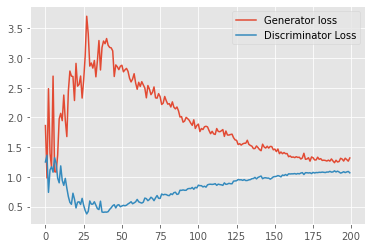

In [29]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('output/loss.png')